# Feature learning - Pretrained Models (ResNET, EfficientNET)

In [1]:
import random
import os, sys

PROJECT_ROOT = os.path.dirname(os.getcwd())
sys.path.append(PROJECT_ROOT)

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from sklearn.model_selection import train_test_split

from utils.mlp_evaluator import MLPEvaluator
from utils.pcam_dataset import PCAMDataset
from utils.get_embeddings_pytorch import get_embeddings_pytorch

random.seed(69420)

In [2]:
DATA_PATH = os.path.join('..', 'data', 'test', 'pcam')
# MISC Parameters
NUM_WORKERS = 0
BATCH_SIZE = 128
IMAGE_SIZE = 96
NUM_CHANNELS = 3
SIZE_Z = 128

NUM_EPOCHS = 20
NUM_GPU = 1
LEARNING_RATE = 0.0002
BETAS = (0.5, 0.999)
sample_interval = 50

## Data preparation

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255.0)
])

# Selecting any of the patches possible
x_path = os.path.join(DATA_PATH, 'camelyonpatch_level_2_split_test_x.h5')
y_path = os.path.join(DATA_PATH, 'camelyonpatch_level_2_split_test_y.h5')

dataset = PCAMDataset(x_path,y_path, transform, normalize= 'reinhard')

train_ratio = 0.80
validation_ratio = 0.15
test_ratio = 0.05

train_indices, valid_indices = train_test_split(range(len(dataset)), train_size= train_ratio)
valid_indices, test_indices = train_test_split(valid_indices, test_size=test_ratio/(test_ratio + validation_ratio))

dataloader = DataLoader(dataset, batch_size= BATCH_SIZE, sampler= valid_indices, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset, batch_size= BATCH_SIZE, sampler= test_indices, num_workers=NUM_WORKERS)

In [10]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and NUM_GPU > 0) else "cpu")
device

device(type='cuda', index=0)

We will use the same MLP architecture to compare the feature representation power each pretrained model holds

In [11]:
mlp_evaluator = MLPEvaluator(device, BATCH_SIZE, NUM_EPOCHS, SIZE_Z, LEARNING_RATE, BETAS, NUM_GPU)

## Resnet 50 - trained on IMAGENET V2 Weights

In [6]:
resnet = models.resnet50(weights='DEFAULT')

if (device.type == 'cuda' and (NUM_GPU > 1)):
    resnet = torch.nn.DataParallel(resnet, list(range(NUM_GPU)))
resnet.fc = torch.nn.Linear(resnet.fc.in_features, SIZE_Z) # type: ignore
summary(resnet, input_size=(BATCH_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 128]                --
├─Conv2d: 1-1                            [128, 64, 48, 48]         9,408
├─BatchNorm2d: 1-2                       [128, 64, 48, 48]         128
├─ReLU: 1-3                              [128, 64, 48, 48]         --
├─MaxPool2d: 1-4                         [128, 64, 24, 24]         --
├─Sequential: 1-5                        [128, 256, 24, 24]        --
│    └─Bottleneck: 2-1                   [128, 256, 24, 24]        --
│    │    └─Conv2d: 3-1                  [128, 64, 24, 24]         4,096
│    │    └─BatchNorm2d: 3-2             [128, 64, 24, 24]         128
│    │    └─ReLU: 3-3                    [128, 64, 24, 24]         --
│    │    └─Conv2d: 3-4                  [128, 64, 24, 24]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 24, 24]         128
│    │    └─ReLU: 3-6                    [128, 64, 24, 24]         --
│ 

In [18]:
# Getting train and test embeddings for the MLP

X_rn_train, y_rn_train = get_embeddings_pytorch(resnet, dataloader, device)
X_rn_test, y_rn_test = get_embeddings_pytorch(resnet, dataloader_test, device)

Epoch [1/20], Loss: 0.6916
Epoch [1/20], Loss: 0.6951
Epoch [1/20], Loss: 0.6897
Epoch [1/20], Loss: 0.6905
Epoch [1/20], Loss: 0.6895
Epoch [1/20], Loss: 0.6908
Epoch [1/20], Loss: 0.6841
Epoch [1/20], Loss: 0.6845
Epoch [1/20], Loss: 0.6866
Epoch [1/20], Loss: 0.6919
Epoch [1/20], Loss: 0.6891
Epoch [1/20], Loss: 0.6885
Epoch [1/20], Loss: 0.6913
Epoch [1/20], Loss: 0.6817
Epoch [1/20], Loss: 0.6904
Epoch [1/20], Loss: 0.6887
Epoch [1/20], Loss: 0.6858
Epoch [1/20], Loss: 0.6825
Epoch [1/20], Loss: 0.6769
Epoch [1/20], Loss: 0.6842
Epoch [1/20], Loss: 0.6877
Epoch [1/20], Loss: 0.6783
Epoch [1/20], Loss: 0.6904
Epoch [1/20], Loss: 0.6775
Epoch [1/20], Loss: 0.6829
Epoch [1/20], Loss: 0.6850
Epoch [1/20], Loss: 0.6887
Epoch [1/20], Loss: 0.6737
Epoch [1/20], Loss: 0.6794
Epoch [1/20], Loss: 0.6787
Epoch [1/20], Loss: 0.6781
Epoch [1/20], Loss: 0.6821
Epoch [1/20], Loss: 0.6757
Epoch [1/20], Loss: 0.6841
Epoch [1/20], Loss: 0.6739
Epoch [1/20], Loss: 0.6729
Epoch [1/20], Loss: 0.6690
E

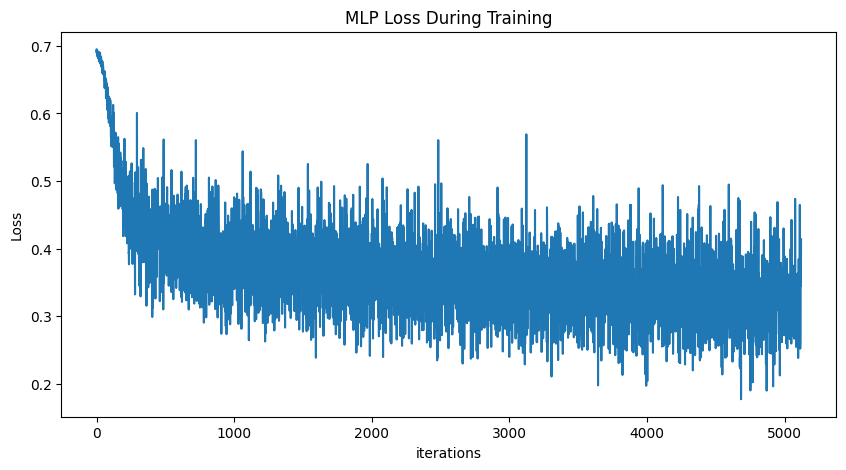

In [19]:
mlp_rn, mlp_rn_losses = mlp_evaluator.train_mlp(X_rn_train, y_rn_train)
plt.figure(figsize=(10,5))
plt.title("MLP Loss During Training")
plt.plot(mlp_rn_losses, label="MLP - RESNET")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

In [20]:
rn_test_accuracy = mlp_evaluator.get_mlp_accuracy(mlp_rn, X_rn_test, y_rn_test)

MLP Accuracy: 0.8615009188652039


## EfficientNET

In [14]:
efficientnet = models.efficientnet_b0(weights = 'DEFAULT')
if (device.type == 'cuda' and (NUM_GPU > 1)):
    efficientnet = torch.nn.DataParallel(efficientnet, list(range(NUM_GPU)))
efficientnet.classifier[1] = torch.nn.Linear(efficientnet.classifier[1].in_features, SIZE_Z) # type: ignore
summary(efficientnet, input_size=(BATCH_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [128, 128]                --
├─Sequential: 1-1                                       [128, 1280, 3, 3]         --
│    └─Conv2dNormActivation: 2-1                        [128, 32, 48, 48]         --
│    │    └─Conv2d: 3-1                                 [128, 32, 48, 48]         864
│    │    └─BatchNorm2d: 3-2                            [128, 32, 48, 48]         64
│    │    └─SiLU: 3-3                                   [128, 32, 48, 48]         --
│    └─Sequential: 2-2                                  [128, 16, 48, 48]         --
│    │    └─MBConv: 3-4                                 [128, 16, 48, 48]         1,448
│    └─Sequential: 2-3                                  [128, 24, 24, 24]         --
│    │    └─MBConv: 3-5                                 [128, 24, 24, 24]         6,004
│    │    └─MBConv: 3-6                              

In [15]:
# Getting train and test embeddings for the MLP

X_en_train, y_en_train = get_embeddings_pytorch(efficientnet, dataloader, device)
X_en_test, y_en_test = get_embeddings_pytorch(efficientnet, dataloader_test, device)

Epoch [1/20], Loss: 0.6972
Epoch [1/20], Loss: 0.6962
Epoch [1/20], Loss: 0.6934
Epoch [1/20], Loss: 0.6896
Epoch [1/20], Loss: 0.7018
Epoch [1/20], Loss: 0.6935
Epoch [1/20], Loss: 0.6983
Epoch [1/20], Loss: 0.7017
Epoch [1/20], Loss: 0.6954
Epoch [1/20], Loss: 0.6915
Epoch [1/20], Loss: 0.6964
Epoch [1/20], Loss: 0.6816
Epoch [1/20], Loss: 0.7005
Epoch [1/20], Loss: 0.6876
Epoch [1/20], Loss: 0.6827
Epoch [1/20], Loss: 0.6874
Epoch [1/20], Loss: 0.6842
Epoch [1/20], Loss: 0.7025
Epoch [1/20], Loss: 0.6831
Epoch [1/20], Loss: 0.6897
Epoch [1/20], Loss: 0.6803
Epoch [1/20], Loss: 0.6898
Epoch [1/20], Loss: 0.6937
Epoch [1/20], Loss: 0.6915
Epoch [1/20], Loss: 0.6830
Epoch [1/20], Loss: 0.6880
Epoch [1/20], Loss: 0.6822
Epoch [1/20], Loss: 0.6829
Epoch [1/20], Loss: 0.6736
Epoch [1/20], Loss: 0.6857
Epoch [1/20], Loss: 0.6784
Epoch [1/20], Loss: 0.6950
Epoch [1/20], Loss: 0.6958
Epoch [1/20], Loss: 0.6836
Epoch [1/20], Loss: 0.6790
Epoch [1/20], Loss: 0.6714
Epoch [1/20], Loss: 0.6808
E

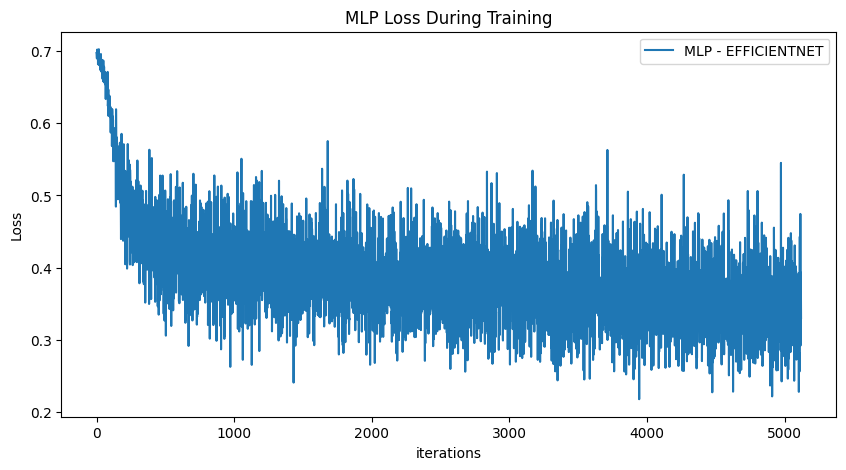

In [16]:
mlp_en, mlp_en_losses = mlp_evaluator.train_mlp(X_en_train, y_en_train)
plt.figure(figsize=(10,5))
plt.title("MLP Loss During Training")
plt.plot(mlp_en_losses, label="MLP - EFFICIENTNET")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
en_test_accuracy = mlp_evaluator.get_mlp_accuracy(mlp_en, X_en_test, y_en_test)

MLP Accuracy: 0.8560097813606262


## Evaluating Embeddings

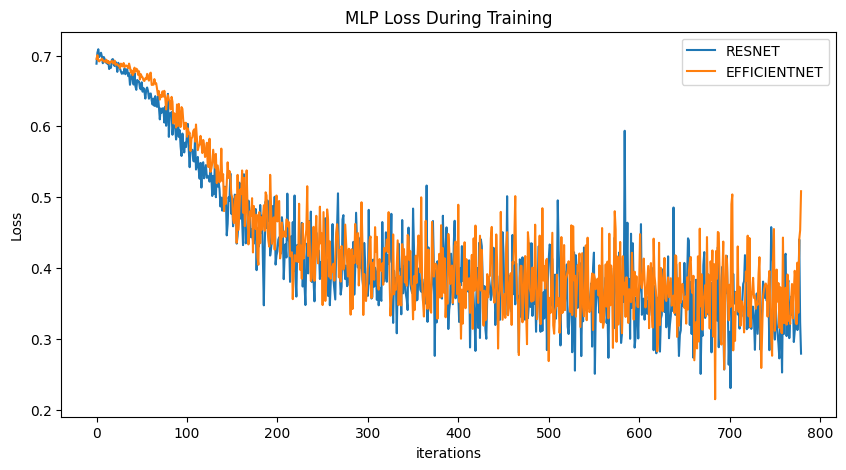

In [15]:
plt.figure(figsize=(10,5))
plt.title("MLP Loss During Training")
plt.plot(mlp_rn_losses, label="RESNET")
plt.plot(mlp_en_losses, label="EFFICIENTNET")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Saliency MAPs of pretrained models